## STEP 1 : 시계열 데이터 준비

    칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
    날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
    우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

company_name =['AMZN','TSLA','NFLX','GOOG']
for i in company_name:
    dataset_filepath = os.getenv('HOME') + f'/aiffel/stock_prediction/data/{i}.csv'
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    globals()['ts_{}'.format(i)] = df['Close'] #변수명에 변화주기, 뭔가 한꺼번에 해볼려다 말았다
    #['AMZN','TSLA','NFLX','GOOG'] ts_파일이름 변수를 생성하고 파일 불러오기 

ts_AMZN.head()

Date
2020-11-11    3137.389893
2020-11-12    3110.280029
2020-11-13    3128.810059
2020-11-16    3131.060059
2020-11-17    3135.659912
Name: Close, dtype: float64

In [55]:
ts_TSLA.head()

Date
2020-11-11    417.130005
2020-11-12    411.760010
2020-11-13    408.500000
2020-11-16    408.089996
2020-11-17    441.609985
Name: Close, dtype: float64

In [56]:
ts_NFLX.head()

Date
2020-11-11    490.760010
2020-11-12    486.769989
2020-11-13    482.839996
2020-11-16    479.100006
2020-11-17    480.630005
Name: Close, dtype: float64

In [57]:
ts = ts_GOOG #밑의 변수명을 다 바꾸기 귀찮아서 한번씩 덮어 씌웠다

## STEP 2 : 각종 전처리 수행

    결측치 처리
    로그 변환

In [58]:
# 결측치 처리
# [[YOUR CODE]]
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [59]:
# 로그 변환
# [[YOUR CODE]]
ts_log = np.log(ts)

## STEP 3 : 시계열 안정성 분석

    정성적 그래프 분석
    정량적 Augmented Dicky-Fuller Test
    시계열 분해(Time Series Decomposition)
    Residual 안정성 확인

In [60]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


In [61]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


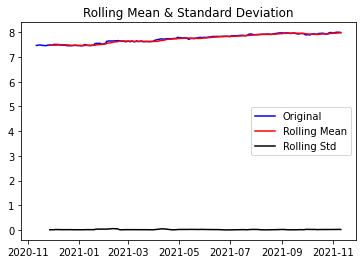

Results of Dickey-Fuller Test:
Test Statistic                  -0.966812
p-value                          0.765176
#Lags Used                       7.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


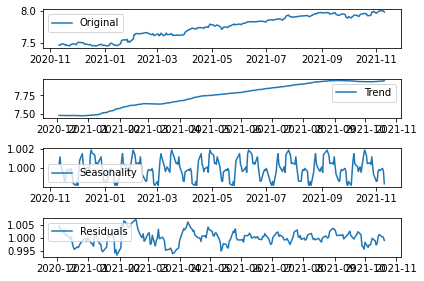

In [62]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
# [[YOUR CODE]]
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [63]:
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.361409
p-value                          0.000347
#Lags Used                       5.000000
Number of Observations Used    216.000000
Critical Value (1%)             -3.460992
Critical Value (5%)             -2.875016
Critical Value (10%)            -2.573952
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

    학습, 테스트 데이터셋 분리

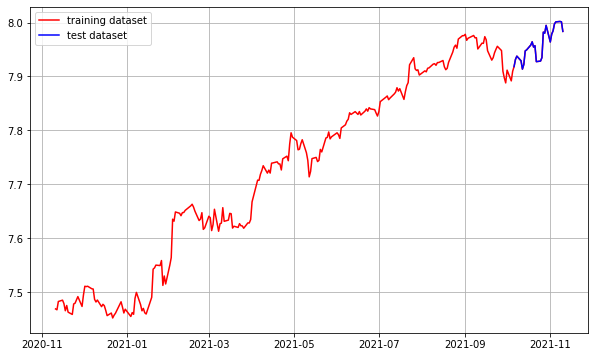

In [64]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

    ACF, PACF 그려보기 -> p,q 구하기
    차분 안정성 확인 -> d 구하기

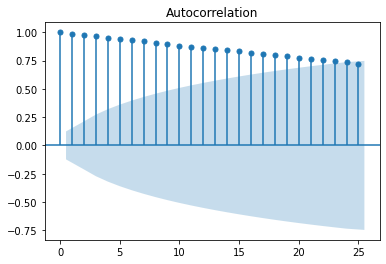

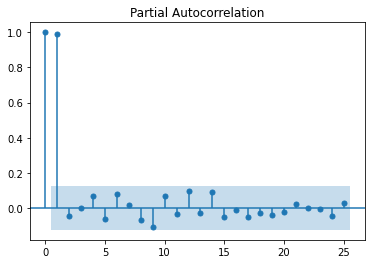

In [65]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -6.222971e+00
p-value                        5.169444e-08
#Lags Used                     6.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.168464e+00
p-value                        2.845375e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


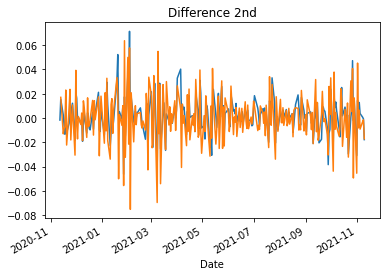

In [66]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

    ARIMA 모델 빌드와 훈련
    모델 테스트 및 플로팅
    최종 예측 모델 정확도 측정(MAPE)

MAPE

평균 절대 백분율 오차(MAPE)는 정확도를 오차의 백분율로 표시합니다. MAPE는 백분율이기 때문에 다른 정확도 측도 통계량보다 더 쉽게 이해할 수 있습니다. 예를 들어 MAPE가 5이면 예측 값은 평균 5% 벗어납니다.

그러나 모형이 데이터를 잘 적합시키는 것으로 보이더라도 MAPE 값이 아주 큰 경우도 있습니다. 0에 가까운 데이터 값이 있는지 확인하려면 그림을 조사하십시오. MAPE는 절대 오차를 실제 데이터로 나누기 때문에 0에 가까운 값이 있으면 MAPE가 상당히 크게 팽창할 수 있습니다.
해석

다른 시계열 모형의 적합치를 비교하는 데 사용하십시오. 값이 작을수록 적합도가 높습니다. 단일 모형에 3개의 정확도 측도 모두에 대한 가장 낮은 값이 없는 경우 MAPE가 일반적으로 많이 사용되는 측정값입니다.

정확도 측도는 한 주기 전 잔차를 기반으로 합니다. 각 시점에서 모형이 다음 시점에 대한 Y 값을 예측하기 위해 사용됩니다. 예측 값(적합치)과 실제 Y 간의 차이가 한 주기 전 잔차입니다. 이 때문에 정확도 측도는 데이터의 끝에서 1주기를 예측할 때 예상할 수 있는 정확도를 나타냅니다. 따라서 2주기 이상 예측하는 경우의 정확도는 나타내지 않습니다. 예측을 위해 모형을 사용하는 경우 정확도 측도만을 기준으로 결정을 내리지 말아야 합니다. 

In [67]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 634.208
Method:                       css-mle   S.D. of innovations              0.014
Date:                Thu, 11 Nov 2021   AIC                          -1262.416
Time:                        06:08:13   BIC                          -1252.168
Sample:                             1   HQIC                         -1258.280
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      2.071      0.038       0.000       0.004
ar.L1.D.Close    -0.0185      0.067     -0.277      0.781      -0.149       0.112
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

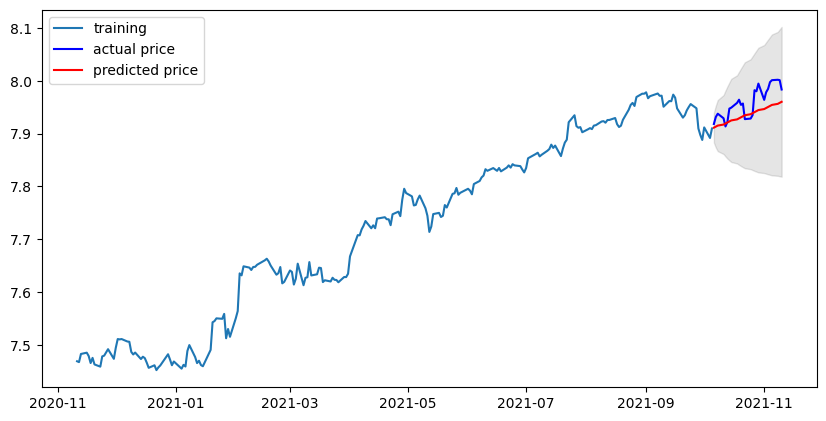

In [68]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [69]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7132.364112874202
MAE:  72.87104740886512
RMSE:  84.45332505516998
MAPE: 2.51%


## STEP 7 : 다른 주식 종목 예측해 보기

    관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

No.|평가문항|상세기준
-|:-|:-
1.| 시계열의 안정성이 충분히 확인되었는가?|플로팅과 adfuller 메소드가 모두 적절히 사용되었음
2.| ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?|p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3.| 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?|3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

### Augmented Dickey-Fuller Test

이번 스텝에서는 Augmented Dickey-Fuller Test(ADF Test) 라는 시계열 데이터의 안정성(stationary)을   
테스트하는 통계적 방법을 소개하려고 합니다.

이 테스트는

        주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후, 

        통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우에 

        이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택한다는 내용입니다. 

### 2. ARIMA 모델의 모수 p, q, d

ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야 합니다. 핵심적인 숫자들을 잘 정해야 올바른 예측식을 구할 수 있다는 것이지요.

ARIMA의 모수는 아래의 3가지가 있습니다

    p : 자기회귀 모형(AR)의 시차
    q : 이동평균 모형(MA)의 시차
    d : 차분누적(I) 횟수

이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

그러면 모수 p, q, d는 어떻게 결정될까요? 여기서부터의 설명이 매우 어렵습니다.

ARIMA의 적절한 모수 p, d, q를 선택하는 방법으로 많은 통계학적인 시도들이 있지만 대표적인 것만 이야기하면 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)를 말할 수 있습니다. 이 AutoCorrelation은 우리가 맨 첫 스텝에서 다룬 개념 중 하나인 자기상관계수와 같은 것입니다.

#### ACF

    시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수
    주어진 시계열의 현재 값이 과거(yt−1,yt−2,....,yt−ny_{t-1}, y_{t-2}, ...., y_{t-n}yt−1​,yt−2​,....,yt−n​) 값과 어떻게 상관되는지 설명함.
    ACF plot에서 X 축은 상관 계수를 나타냄, y축은 시차 수를 나타냄

#### PACF

    다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수
    k 이외의 모든 시차를 갖는 관측치(yt−1,yt−2,....,yt−k+1y_{t-1}, y_{t-2}, ...., y_{t-k+1}yt−1​,yt−2​,....,yt−k+1​)의 영향력을 배제한 가운데 특정 두 관측치, yty_{t}yt​와 yt−ky_{t-k}yt−k​가 얼마나 관련이 있는지 나타내는 척도.

## 회고
음 lms가 워낙 잘되있어서 따로 수정해보는건 데이터나 도입부 정도 밖에 없었다   
하지만 실제의 결과를 예측해 보고 그 오차율이 실제로 나오는 것을 보니   
학습에 대한 의욕과 호기심이 늘어난다   
나중에 다시 볼 생각으로 관련 개념과 노드 내용을 담고있다 괜히 길어져서 보기 불편할 퍼실님께 미안합니다

## 결과모음 (넷플릭스,테슬라,아마존,구글)

### NFLX(넷플릭스)

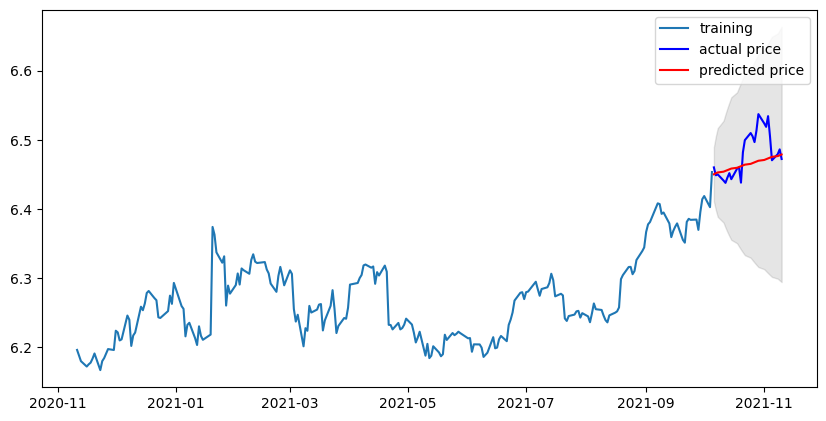

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [19]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  400.2364215160851
MAE:  15.044433088268573
RMSE:  20.005909664798676
MAPE: 2.26%


---
### TSLA(테슬라)

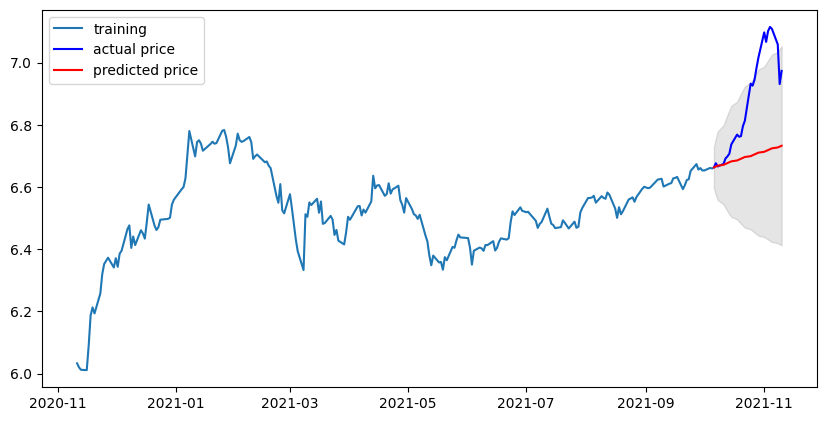

In [36]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [37]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  47892.812983420285
MAE:  166.51054025590082
RMSE:  218.8442665079903
MAPE: 15.16%


크게 급등한 부분은 예측하지 못했다. 시계열 데이터의 안정성이 부족하다고 볼수있겠다 (안정성은 과거에 일어난 일이 미래에도 일어날꺼라고 예측함으로 돌발적인 급등은 안정성이 부족하다)

---
### AMZN(아마존)

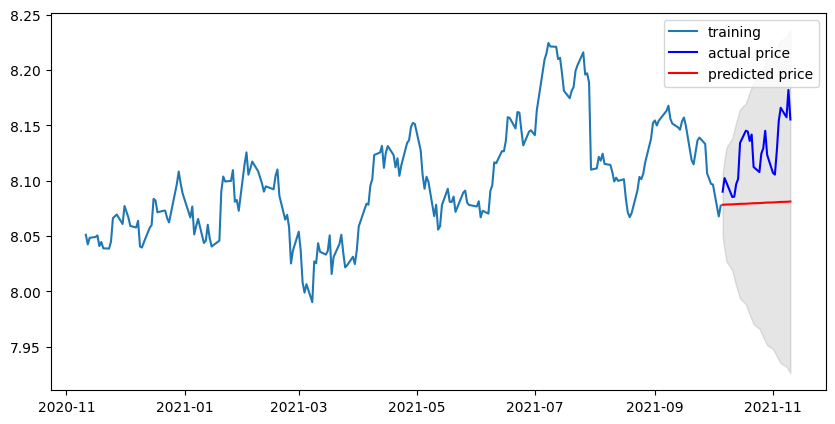

In [52]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [53]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30400.11594786288
MAE:  151.72186988001766
RMSE:  174.35629024461056
MAPE: 4.43%


예측값이 상당히 실제수치와 달라보이는데 MAPE는 5프로 이하로 나왔다

---
### GOOG(구글)

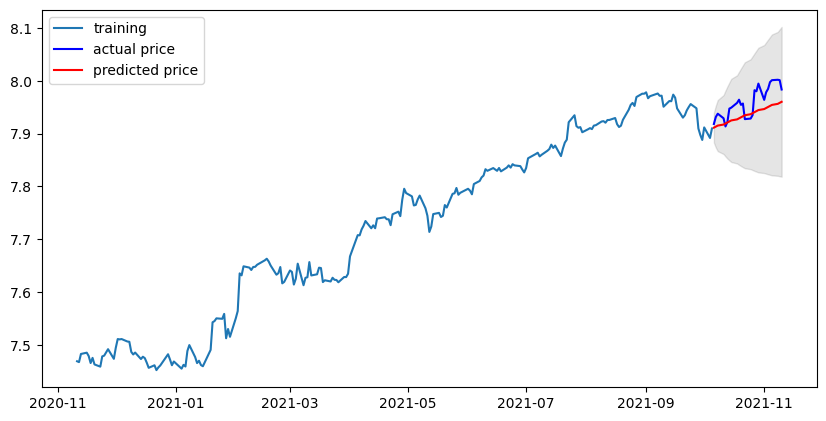

In [68]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [69]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7132.364112874202
MAE:  72.87104740886512
RMSE:  84.45332505516998
MAPE: 2.51%


잘 예측되었다